# Notebook 2-1: Predicting CO2 emissions using Neural Networks

Readme: In this notebook, NN models are constructed for CO2 Emission prediction, and the best model is selected and K-means validation is applied.

- **Notebook content**:
    - Design the architecture of NN and explore different model configuration

    - Tune hyperparameters and select the best model

- **Notebook Output**:

    - Best model file

    - The validation and test results of the best Neural Netwrok model

In [3]:
# %pip install "numpy<2" torch torchvision scikit-learn
# %pip install wandb

In [4]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## 1 Define Functions

In [5]:
# Define functions
import seaborn as sns
import torch

# 1 plot related functions----------------
# plot predict and true values on validation dataset
def plot_pred_true(y_test, y_pred, ax):

    data = pd.DataFrame({'y_obs': y_test, 'y_pred': y_pred})

    # plt.figure(figsize=(5, 5))
    sns.scatterplot(data=data, x='y_obs', y='y_pred', s=10, ax=ax)
    ax.plot(y_test, y_test, color='red', label='y=x')          # plot the line y=x
    ax.set_title('Observed vs Predicted values in Test Dataset')   # title
    ax.set_xlabel('Observed values')       # label for the x-axis
    ax.set_ylabel('Predicted values')      # label for the y-axis
    ax.legend()
    ax.grid(True)

# plot the loss value on training and validation dataset
def plot_train_val_loss(train_loss, val_loss, ax):
    
    # ax.figure(figsize=(5, 5))

    ax.plot(train_loss, label='train loss')
    ax.plot(val_loss, label='val loss')
    ax.set_title('Train vs Validation Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True)

# 2 Other functions---------------------
# get the prediction and true values
def model_prediction(model, val_loader, device):

    model.eval()
    pred = []
    target = []

    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)

            y_pred = model(X)      # predicted value

            pred.extend(y_pred.cpu().numpy())
            target.extend(y.cpu().numpy())

    # Merge all the predictions and targets
    predictions = np.concatenate(pred, axis=0)
    labels = np.concatenate(target, axis=0)
    return predictions, labels

## 2 Data Preparation

In [6]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

### Load and Divide Traning and Testing Data

Load the test and train dataset

In [7]:
# Import data
trainset_df = pd.read_csv('Dataset1_train.csv')
testset_df = pd.read_csv('Dataset1_test.csv')


In [8]:
trainset_df

,Engine Size(L),Cylinders,Gearbox_Type,Gearbox_Number,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),Model Features_Flexible-fuel vehicle,Model Features_Four-wheel drive,...,Vehicle Class_SUV - SMALL,Vehicle Class_SUV - STANDARD,Vehicle Class_TWO-SEATER,Vehicle Class_VAN - CARGO,Vehicle Class_VAN - PASSENGER,Fuel Type_E,Fuel Type_X,Fuel Type_Z,Make,CO2 Emissions(g/km)
0,4.0,6,1,5.000000,14.7,10.3,12.7,22,0,0,...,0,0,0,0,0,0,1,0,NISSAN,299
1,2.4,4,1,6.000000,9.8,6.7,8.4,34,0,0,...,0,0,0,0,0,0,1,0,HYUNDAI,193
2,2.0,4,1,8.000000,11.3,7.1,9.4,30,0,0,...,0,0,0,0,0,0,0,1,BMW,221
3,2.5,4,1,6.000000,10.1,7.7,9.0,31,0,0,...,1,0,0,0,0,0,1,0,TOYOTA,212
4,5.0,8,1,8.000000,15.8,10.3,13.3,21,0,0,...,0,0,0,0,0,0,0,1,JAGUAR,313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5902,2.0,4,1,6.000000,9.3,7.3,8.4,34,0,0,...,0,0,0,0,0,0,0,1,MINI,197
5903,5.6,8,1,7.000000,17.5,12.8,15.4,18,0,1,...,0,1,0,0,0,0,1,0,NISSAN,362
5904,3.5,6,1,6.000000,8.1,8.5,8.3,34,0,0,...,0,1,0,0,0,0,1,0,TOYOTA,193
5905,2.5,4,1,6.854093,9.5,7.4,8.6,33,0,0,...,1,0,0,0,0,0,1,0,NISSAN,198


In [9]:
X_train = trainset_df.drop(columns=['CO2 Emissions(g/km)', 'Make'])
y_train = trainset_df['CO2 Emissions(g/km)']

X_test = testset_df.drop(columns=['CO2 Emissions(g/km)', 'Make'])
y_test = testset_df['CO2 Emissions(g/km)']

In [10]:
X_train

,Engine Size(L),Cylinders,Gearbox_Type,Gearbox_Number,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),Model Features_Flexible-fuel vehicle,Model Features_Four-wheel drive,...,Vehicle Class_STATION WAGON - SMALL,Vehicle Class_SUBCOMPACT,Vehicle Class_SUV - SMALL,Vehicle Class_SUV - STANDARD,Vehicle Class_TWO-SEATER,Vehicle Class_VAN - CARGO,Vehicle Class_VAN - PASSENGER,Fuel Type_E,Fuel Type_X,Fuel Type_Z
0,4.0,6,1,5.000000,14.7,10.3,12.7,22,0,0,...,0,0,0,0,0,0,0,0,1,0
1,2.4,4,1,6.000000,9.8,6.7,8.4,34,0,0,...,0,0,0,0,0,0,0,0,1,0
2,2.0,4,1,8.000000,11.3,7.1,9.4,30,0,0,...,0,1,0,0,0,0,0,0,0,1
3,2.5,4,1,6.000000,10.1,7.7,9.0,31,0,0,...,0,0,1,0,0,0,0,0,1,0
4,5.0,8,1,8.000000,15.8,10.3,13.3,21,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5902,2.0,4,1,6.000000,9.3,7.3,8.4,34,0,0,...,0,1,0,0,0,0,0,0,0,1
5903,5.6,8,1,7.000000,17.5,12.8,15.4,18,0,1,...,0,0,0,1,0,0,0,0,1,0
5904,3.5,6,1,6.000000,8.1,8.5,8.3,34,0,0,...,0,0,0,1,0,0,0,0,1,0
5905,2.5,4,1,6.854093,9.5,7.4,8.6,33,0,0,...,0,0,1,0,0,0,0,0,1,0


### Setup pipline for Standardisation

In [11]:
binary_columns = X_train.columns[X_train.nunique() == 2].tolist()  
numerical_columns = [col for col in X_train.columns if col not in binary_columns]

# ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns)  # StandardScale
    ], 
    remainder='passthrough'  # keep dummy variable
)

# Setup pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

In [12]:
X_train_processed = pipeline.fit_transform(X_train)
X_test_processed = pipeline.transform(X_test)

Inspect the processed data

In [13]:
feature_names = list(X_train) 
X_train_df = pd.DataFrame(X_train_processed, columns=feature_names)

X_test_df = pd.DataFrame(X_test_processed, columns=feature_names)

print("Processed Train Dataset：")
print(X_train_df.head())

print("Processed Test Dataset：")
print(X_test_df.head())


Processed Train Dataset：
   Engine Size(L)  Cylinders  Gearbox_Type  Gearbox_Number  \
0        0.612690   0.200638     -1.602571        0.606404   
1       -0.567895  -0.889172     -0.750938       -0.792804   
2       -0.863042  -0.889172      0.952329       -0.364475   
3       -0.494109  -0.889172     -0.750938       -0.707138   
4        1.350555   1.290448      0.952329        0.920512   

   Fuel Consumption City (L/100 km)  Fuel Consumption Hwy (L/100 km)  \
0                          0.563352                         0.591736   
1                         -1.064801                        -0.897681   
2                         -0.883895                        -0.551305   
3                         -0.612536                        -0.689855   
4                          0.563352                         0.799561   

   Fuel Consumption Comb (L/100 km)  Fuel Consumption Comb (mpg)  \
0                         -0.753140                          1.0   
1                          0.9101

In [14]:
# Prepare the Dataloader
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Convert data to Tensor
X_train_tensor = torch.tensor(X_train_processed, dtype=torch.float32) 
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)

X_val_tensor = torch.tensor(X_test_processed, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Load the training data and validation data
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_val_tensor,y_test_tensor)

# Set hyperparameters
batch_size = 64  # batch size

# Create data loader
train_Loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_Loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)



## 3 Best Models

#### Pre: k-fold Import K-fold Cross-validation Method

In [15]:
from sklearn.model_selection import KFold

k_fold = KFold(n_splits=20, shuffle=True, random_state=42) # Set randon seed to make sure the results are reproducible

Import metrics

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

### 3.1 Neural Network Model

#### 3.1.1 Use W&B Grid Search to Find Best NN Parameter Set

In [17]:
import wandb

wandb.login(key="47ea61c7ee69e2e0e1cc46ed5c31bd6168f9f9db")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\87383\_netrc
wandb: Currently logged in as: yixuan228 (yixuan228-imperial-college-london) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

Neural Network Structure

In [18]:
class MultiLayerPerceptron(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(MultiLayerPerceptron, self).__init__()

        # Initialise an empty list to hold layers
        layers = []

        # First layer: input to hidden
        layers.append(nn.Linear(input_size, hidden_size))
        layers.append(nn.ReLU())

        # Additional hidden layers
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())
            
        # Output layer: hidden to output
        layers.append(nn.Linear(hidden_size, output_size))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [19]:
from torch.utils.data import random_split

# Calculate the sizes for train and validation splits
num_total = len(train_dataset)
num_train = int(0.9 * num_total)
num_val = num_total - num_train

# Split the dataset
train_subset, val_subset = random_split(train_dataset, [num_train, num_val])

# Create DataLoaders for each subset
train_Loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_Loader = DataLoader(val_subset, batch_size=64, shuffle=False)

In [ ]:
# Hyperparameter grid
hidden_units_options = [32, 64, 128]    # Numbers of neurons in each hidden layer
hidden_layers_options = [2, 3, 4]       # Numbers of hidden layers
learning_rates = [0.1, 0.01, 0.001]     # Learning rates

max_epochs = 200  # Arbitrarily large; early stopping will likely stop earlier.
patience = 5      # Early stopping patience

input_size =  X_train_processed.shape[1]   # Input size 
output_size = 1             # Output size

learning_rate = 0.02        # Learning rate
n_epochs = 100 # Numebr of epochs

# Define the loss function and the optimizer
criterion = nn.MSELoss()    # Mean Squared Error for Linear Regression


In [21]:
# Define helper functions
# Train epoch function
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    # for features, target in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
    for features, target in train_loader:
        features, target = features.to(device), target.to(device)

        optimizer.zero_grad()
        outputs = model(features) # Forward pass
        loss = criterion(outputs, target)

        loss.backward()  # Backward pass
        optimizer.step() # Update the weights

        running_loss += loss.item() * features.size(0)

    return running_loss / len(train_loader.dataset)

# Validation epoch function
def val_epoch(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for features, target in val_loader:
            # print(featuresfeatures.size(0))
            features, target = features.to(device), target.to(device)
            # features = features.view(features.size(0), -1)

            outputs = model(features)
            loss = criterion(outputs, target)
            val_loss += loss.item() * features.size(0)

    return val_loss / len(val_loader.dataset)



In [22]:
from itertools import product
import torch.optim as optim

for hidden_units, hidden_layers, lr in product(hidden_units_options, hidden_layers_options, learning_rates):

    # Configurations
    config = {
        "hidden_units": hidden_units,
        "hidden_layers": hidden_layers,
        "learning_rate": lr,
        "max_epochs": max_epochs,
        "patience": patience
    }

    # Start a new W&B run for each configuration
    wandb.init(project='DE_Groupwork_G4_stage1', config=config, reinit=True)

    model = MultiLayerPerceptron(input_size=input_size, 
                             hidden_size=config["hidden_units"], 
                             num_layers=config["hidden_layers"], 
                             output_size=1).to(device)


    criterion = nn.MSELoss() 
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_test_loss = float('inf')
    epochs_without_improvement = 0
        
    for epoch in range(1, max_epochs + 1):
        train_loss = train_epoch(model, train_Loader, criterion, optimizer, device)
       
        test_loss = val_epoch(model, test_Loader, criterion, device)

        # Log metrics to W&B
        wandb.log({"epoch": epoch, "train_loss": train_loss, "val_loss": test_loss})
        
        print(f"Epoch {epoch:03d} | Train Loss: {train_loss:.4f} | Val Loss: {test_loss:.4f}")
        
        # Early stopping check
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            
        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered at epoch {epoch}")
            break

    wandb.finish()

print("Training complete for all configurations.")


Epoch 001 | Train Loss: 5514.3652 | Val Loss: 440.5253
Epoch 002 | Train Loss: 301.6506 | Val Loss: 291.4257
Epoch 003 | Train Loss: 166.5759 | Val Loss: 127.7658
Epoch 004 | Train Loss: 68.1235 | Val Loss: 35.9764
Epoch 005 | Train Loss: 28.7847 | Val Loss: 45.6393
Epoch 006 | Train Loss: 34.9599 | Val Loss: 57.6941
Epoch 007 | Train Loss: 26.3130 | Val Loss: 17.1925
Epoch 008 | Train Loss: 18.6134 | Val Loss: 30.7613
Epoch 009 | Train Loss: 22.5218 | Val Loss: 34.4147
Epoch 010 | Train Loss: 38.5950 | Val Loss: 16.7461
Epoch 011 | Train Loss: 24.2420 | Val Loss: 23.8449
Epoch 012 | Train Loss: 20.8000 | Val Loss: 53.2929
Epoch 013 | Train Loss: 21.0842 | Val Loss: 22.8939
Epoch 014 | Train Loss: 19.5026 | Val Loss: 22.3515
Epoch 015 | Train Loss: 46.2849 | Val Loss: 72.0386
Early stopping triggered at epoch 15


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▃▁▁▂▁▁▁▁▁▂▁▁▂
epoch,15
train_loss,46.28491
val_loss,72.03858


Epoch 001 | Train Loss: 23863.2434 | Val Loss: 1251.1614
Epoch 002 | Train Loss: 825.5434 | Val Loss: 668.0640
Epoch 003 | Train Loss: 527.7402 | Val Loss: 468.2074
Epoch 004 | Train Loss: 377.9205 | Val Loss: 358.9596
Epoch 005 | Train Loss: 288.5597 | Val Loss: 300.4213
Epoch 006 | Train Loss: 240.6930 | Val Loss: 247.2153
Epoch 007 | Train Loss: 195.1202 | Val Loss: 203.5134
Epoch 008 | Train Loss: 162.2772 | Val Loss: 165.7341
Epoch 009 | Train Loss: 130.5563 | Val Loss: 137.5243
Epoch 010 | Train Loss: 104.9276 | Val Loss: 105.7664
Epoch 011 | Train Loss: 82.3896 | Val Loss: 78.6683
Epoch 012 | Train Loss: 65.2086 | Val Loss: 59.8034
Epoch 013 | Train Loss: 49.8220 | Val Loss: 44.4299
Epoch 014 | Train Loss: 38.2347 | Val Loss: 35.3417
Epoch 015 | Train Loss: 30.3602 | Val Loss: 32.8647
Epoch 016 | Train Loss: 25.6547 | Val Loss: 26.1879
Epoch 017 | Train Loss: 23.1391 | Val Loss: 22.5498
Epoch 018 | Train Loss: 20.5461 | Val Loss: 20.3826
Epoch 019 | Train Loss: 18.2424 | Val Los

epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,32
train_loss,13.65431
val_loss,13.22943


Epoch 001 | Train Loss: 65838.1324 | Val Loss: 62727.3800
Epoch 002 | Train Loss: 54614.3244 | Val Loss: 38720.2052
Epoch 003 | Train Loss: 21203.9080 | Val Loss: 7151.1598
Epoch 004 | Train Loss: 4461.0233 | Val Loss: 3094.8117
Epoch 005 | Train Loss: 2529.4209 | Val Loss: 2057.7328
Epoch 006 | Train Loss: 1709.6475 | Val Loss: 1494.2635
Epoch 007 | Train Loss: 1282.3153 | Val Loss: 1202.1818
Epoch 008 | Train Loss: 1058.1871 | Val Loss: 1038.0748
Epoch 009 | Train Loss: 929.7856 | Val Loss: 936.1142
Epoch 010 | Train Loss: 839.8108 | Val Loss: 854.3498
Epoch 011 | Train Loss: 764.8624 | Val Loss: 782.2968
Epoch 012 | Train Loss: 700.0018 | Val Loss: 718.0412
Epoch 013 | Train Loss: 641.4499 | Val Loss: 659.0711
Epoch 014 | Train Loss: 588.0201 | Val Loss: 607.9185
Epoch 015 | Train Loss: 537.9103 | Val Loss: 557.1420
Epoch 016 | Train Loss: 491.2554 | Val Loss: 508.6399
Epoch 017 | Train Loss: 451.1200 | Val Loss: 470.8725
Epoch 018 | Train Loss: 416.7761 | Val Loss: 438.0512
Epoch 0

epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇█
train_loss,█▇▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,117
train_loss,10.38248
val_loss,11.08701


Epoch 001 | Train Loss: 11451.1374 | Val Loss: 557.7693
Epoch 002 | Train Loss: 397.5960 | Val Loss: 313.9110
Epoch 003 | Train Loss: 243.2129 | Val Loss: 1023.0517
Epoch 004 | Train Loss: 228.8051 | Val Loss: 272.6789
Epoch 005 | Train Loss: 120.3183 | Val Loss: 150.0033
Epoch 006 | Train Loss: 87.3621 | Val Loss: 86.5757
Epoch 007 | Train Loss: 58.2783 | Val Loss: 95.8038
Epoch 008 | Train Loss: 42.2940 | Val Loss: 32.4085
Epoch 009 | Train Loss: 37.1543 | Val Loss: 47.6369
Epoch 010 | Train Loss: 37.7617 | Val Loss: 38.7426
Epoch 011 | Train Loss: 30.5741 | Val Loss: 34.4765
Epoch 012 | Train Loss: 30.7153 | Val Loss: 43.0984
Epoch 013 | Train Loss: 34.6425 | Val Loss: 287.8606
Early stopping triggered at epoch 13


epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅▃█▃▂▁▁▁▁▁▁▁▃
epoch,13
train_loss,34.64252
val_loss,287.86059


Epoch 001 | Train Loss: 18428.1494 | Val Loss: 870.7166
Epoch 002 | Train Loss: 575.7267 | Val Loss: 450.8282
Epoch 003 | Train Loss: 337.9658 | Val Loss: 317.2982
Epoch 004 | Train Loss: 242.4845 | Val Loss: 242.5317
Epoch 005 | Train Loss: 184.8894 | Val Loss: 183.3792
Epoch 006 | Train Loss: 144.1145 | Val Loss: 150.2437
Epoch 007 | Train Loss: 102.1989 | Val Loss: 104.8404
Epoch 008 | Train Loss: 71.3942 | Val Loss: 69.3625
Epoch 009 | Train Loss: 49.8376 | Val Loss: 46.8339
Epoch 010 | Train Loss: 37.5472 | Val Loss: 47.7637
Epoch 011 | Train Loss: 31.6554 | Val Loss: 33.1472
Epoch 012 | Train Loss: 26.9610 | Val Loss: 23.2333
Epoch 013 | Train Loss: 21.9018 | Val Loss: 29.4420
Epoch 014 | Train Loss: 19.6159 | Val Loss: 25.2177
Epoch 015 | Train Loss: 19.2451 | Val Loss: 17.7899
Epoch 016 | Train Loss: 19.1624 | Val Loss: 28.6692
Epoch 017 | Train Loss: 18.9880 | Val Loss: 27.6188
Epoch 018 | Train Loss: 16.0129 | Val Loss: 15.4588
Epoch 019 | Train Loss: 15.1535 | Val Loss: 15.2

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,31
train_loss,14.99631
val_loss,14.82151


Epoch 001 | Train Loss: 64873.1669 | Val Loss: 56562.5864
Epoch 002 | Train Loss: 24926.7226 | Val Loss: 3807.5320
Epoch 003 | Train Loss: 2424.2887 | Val Loss: 1506.0025
Epoch 004 | Train Loss: 1151.5091 | Val Loss: 941.4628
Epoch 005 | Train Loss: 795.4116 | Val Loss: 746.2495
Epoch 006 | Train Loss: 650.8445 | Val Loss: 636.9987
Epoch 007 | Train Loss: 559.8196 | Val Loss: 560.6160
Epoch 008 | Train Loss: 491.0100 | Val Loss: 497.1460
Epoch 009 | Train Loss: 436.4030 | Val Loss: 442.8254
Epoch 010 | Train Loss: 386.1083 | Val Loss: 398.8524
Epoch 011 | Train Loss: 344.9536 | Val Loss: 361.3860
Epoch 012 | Train Loss: 309.9154 | Val Loss: 326.2331
Epoch 013 | Train Loss: 282.9582 | Val Loss: 297.7430
Epoch 014 | Train Loss: 254.3004 | Val Loss: 273.2639
Epoch 015 | Train Loss: 231.8024 | Val Loss: 254.1740
Epoch 016 | Train Loss: 212.6839 | Val Loss: 232.4560
Epoch 017 | Train Loss: 196.5894 | Val Loss: 218.1047
Epoch 018 | Train Loss: 179.9133 | Val Loss: 197.8944
Epoch 019 | Train 

epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,63
train_loss,11.8207
val_loss,16.3096


Epoch 001 | Train Loss: 26766.4467 | Val Loss: 644.9441
Epoch 002 | Train Loss: 442.3205 | Val Loss: 401.9757
Epoch 003 | Train Loss: 241.9671 | Val Loss: 228.6630
Epoch 004 | Train Loss: 165.9512 | Val Loss: 136.9690
Epoch 005 | Train Loss: 100.0234 | Val Loss: 187.7434
Epoch 006 | Train Loss: 67.9932 | Val Loss: 71.4314
Epoch 007 | Train Loss: 63.9938 | Val Loss: 77.2814
Epoch 008 | Train Loss: 56.3210 | Val Loss: 33.3553
Epoch 009 | Train Loss: 44.3994 | Val Loss: 160.8195
Epoch 010 | Train Loss: 44.9753 | Val Loss: 28.0618
Epoch 011 | Train Loss: 40.5712 | Val Loss: 45.7108
Epoch 012 | Train Loss: 32.9449 | Val Loss: 29.8781
Epoch 013 | Train Loss: 41.8035 | Val Loss: 180.1188
Epoch 014 | Train Loss: 70.7855 | Val Loss: 41.5247
Epoch 015 | Train Loss: 38.3057 | Val Loss: 203.8273
Early stopping triggered at epoch 15


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▂▃▁▂▁▃▁▁▁▃▁▃
epoch,15
train_loss,38.30572
val_loss,203.82733


Epoch 001 | Train Loss: 15914.4994 | Val Loss: 719.5684
Epoch 002 | Train Loss: 468.5913 | Val Loss: 374.5527
Epoch 003 | Train Loss: 282.8233 | Val Loss: 271.0773
Epoch 004 | Train Loss: 207.6701 | Val Loss: 193.7281
Epoch 005 | Train Loss: 146.9252 | Val Loss: 144.5925
Epoch 006 | Train Loss: 109.1775 | Val Loss: 106.1711
Epoch 007 | Train Loss: 84.9477 | Val Loss: 82.4004
Epoch 008 | Train Loss: 57.9822 | Val Loss: 54.2627
Epoch 009 | Train Loss: 44.6477 | Val Loss: 36.0968
Epoch 010 | Train Loss: 31.9844 | Val Loss: 31.6744
Epoch 011 | Train Loss: 28.6559 | Val Loss: 27.7706
Epoch 012 | Train Loss: 24.4294 | Val Loss: 22.1053
Epoch 013 | Train Loss: 21.8609 | Val Loss: 24.3923
Epoch 014 | Train Loss: 19.3540 | Val Loss: 23.3959
Epoch 015 | Train Loss: 18.6029 | Val Loss: 16.0286
Epoch 016 | Train Loss: 16.2239 | Val Loss: 16.7123
Epoch 017 | Train Loss: 15.9016 | Val Loss: 17.4880
Epoch 018 | Train Loss: 18.7476 | Val Loss: 23.3171
Epoch 019 | Train Loss: 16.1545 | Val Loss: 13.079

epoch,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,24
train_loss,15.86571
val_loss,14.53719


Epoch 001 | Train Loss: 64286.1857 | Val Loss: 49727.7806
Epoch 002 | Train Loss: 12736.5169 | Val Loss: 2302.1208
Epoch 003 | Train Loss: 1457.5832 | Val Loss: 991.1661
Epoch 004 | Train Loss: 769.7400 | Val Loss: 689.0896
Epoch 005 | Train Loss: 564.3495 | Val Loss: 544.3187
Epoch 006 | Train Loss: 456.2097 | Val Loss: 458.8016
Epoch 007 | Train Loss: 385.3409 | Val Loss: 397.1559
Epoch 008 | Train Loss: 333.1901 | Val Loss: 352.7432
Epoch 009 | Train Loss: 295.1640 | Val Loss: 315.9600
Epoch 010 | Train Loss: 263.0311 | Val Loss: 285.8921
Epoch 011 | Train Loss: 235.4585 | Val Loss: 257.2322
Epoch 012 | Train Loss: 211.4513 | Val Loss: 233.7086
Epoch 013 | Train Loss: 193.4883 | Val Loss: 217.1710
Epoch 014 | Train Loss: 176.8994 | Val Loss: 199.6250
Epoch 015 | Train Loss: 165.2853 | Val Loss: 185.7943
Epoch 016 | Train Loss: 150.4003 | Val Loss: 169.5224
Epoch 017 | Train Loss: 138.3580 | Val Loss: 155.7101
Epoch 018 | Train Loss: 126.5505 | Val Loss: 143.0334
Epoch 019 | Train Lo

epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
train_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,83
train_loss,11.26295
val_loss,16.27845


Epoch 001 | Train Loss: 4081.7235 | Val Loss: 324.9527
Epoch 002 | Train Loss: 223.2913 | Val Loss: 202.4638
Epoch 003 | Train Loss: 135.0953 | Val Loss: 96.4624
Epoch 004 | Train Loss: 46.7280 | Val Loss: 37.7374
Epoch 005 | Train Loss: 37.1548 | Val Loss: 62.4236
Epoch 006 | Train Loss: 34.3235 | Val Loss: 287.2881
Epoch 007 | Train Loss: 131.2291 | Val Loss: 73.8424
Epoch 008 | Train Loss: 49.2942 | Val Loss: 120.6454
Epoch 009 | Train Loss: 31.5865 | Val Loss: 33.2805
Epoch 010 | Train Loss: 35.7304 | Val Loss: 86.4624
Epoch 011 | Train Loss: 34.2364 | Val Loss: 277.5478
Epoch 012 | Train Loss: 172.2996 | Val Loss: 26.4838
Epoch 013 | Train Loss: 39.0475 | Val Loss: 41.0160
Epoch 014 | Train Loss: 33.7832 | Val Loss: 34.3450
Epoch 015 | Train Loss: 62.4275 | Val Loss: 88.5084
Epoch 016 | Train Loss: 94.0782 | Val Loss: 64.0572
Epoch 017 | Train Loss: 43.5610 | Val Loss: 146.5342
Early stopping triggered at epoch 17


epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▁▂▇▂▃▁▂▇▁▁▁▂▂▄
epoch,17
train_loss,43.56098
val_loss,146.53417


Epoch 001 | Train Loss: 16426.4087 | Val Loss: 926.5649
Epoch 002 | Train Loss: 609.6639 | Val Loss: 484.6788
Epoch 003 | Train Loss: 365.8155 | Val Loss: 327.6488
Epoch 004 | Train Loss: 262.3564 | Val Loss: 247.7678
Epoch 005 | Train Loss: 200.1812 | Val Loss: 196.9179
Epoch 006 | Train Loss: 152.2671 | Val Loss: 163.5936
Epoch 007 | Train Loss: 119.1730 | Val Loss: 114.0712
Epoch 008 | Train Loss: 84.8473 | Val Loss: 82.5549
Epoch 009 | Train Loss: 60.6927 | Val Loss: 54.0426
Epoch 010 | Train Loss: 43.3781 | Val Loss: 42.7554
Epoch 011 | Train Loss: 35.2136 | Val Loss: 33.5125
Epoch 012 | Train Loss: 29.6980 | Val Loss: 27.7967
Epoch 013 | Train Loss: 24.3891 | Val Loss: 25.6638
Epoch 014 | Train Loss: 20.5537 | Val Loss: 25.5027
Epoch 015 | Train Loss: 22.7101 | Val Loss: 18.1397
Epoch 016 | Train Loss: 18.4347 | Val Loss: 17.4455
Epoch 017 | Train Loss: 17.6126 | Val Loss: 20.6706
Epoch 018 | Train Loss: 17.7241 | Val Loss: 17.3693
Epoch 019 | Train Loss: 14.7780 | Val Loss: 13.6

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,31
train_loss,14.32073
val_loss,12.49437


Epoch 001 | Train Loss: 64038.5590 | Val Loss: 54789.3547
Epoch 002 | Train Loss: 30864.9801 | Val Loss: 7901.5013
Epoch 003 | Train Loss: 4053.3358 | Val Loss: 2345.1438
Epoch 004 | Train Loss: 1811.8089 | Val Loss: 1420.9658
Epoch 005 | Train Loss: 1182.5176 | Val Loss: 1052.7913
Epoch 006 | Train Loss: 916.0443 | Val Loss: 879.1197
Epoch 007 | Train Loss: 777.1222 | Val Loss: 770.0482
Epoch 008 | Train Loss: 686.3726 | Val Loss: 693.2808
Epoch 009 | Train Loss: 616.7143 | Val Loss: 625.2774
Epoch 010 | Train Loss: 558.5850 | Val Loss: 571.6644
Epoch 011 | Train Loss: 508.1049 | Val Loss: 521.3971
Epoch 012 | Train Loss: 464.8270 | Val Loss: 479.9233
Epoch 013 | Train Loss: 425.1897 | Val Loss: 442.3012
Epoch 014 | Train Loss: 392.1687 | Val Loss: 412.4030
Epoch 015 | Train Loss: 363.1973 | Val Loss: 383.6280
Epoch 016 | Train Loss: 337.8790 | Val Loss: 359.4900
Epoch 017 | Train Loss: 315.6288 | Val Loss: 337.9199
Epoch 018 | Train Loss: 295.9137 | Val Loss: 320.6513
Epoch 019 | Tra

epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█
train_loss,█▄▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,100
train_loss,11.21322
val_loss,11.94151


Epoch 001 | Train Loss: 14498.0853 | Val Loss: 437.0465
Epoch 002 | Train Loss: 265.1527 | Val Loss: 194.1292
Epoch 003 | Train Loss: 170.0533 | Val Loss: 120.4431
Epoch 004 | Train Loss: 66.4976 | Val Loss: 44.6717
Epoch 005 | Train Loss: 33.4636 | Val Loss: 32.1230
Epoch 006 | Train Loss: 26.8316 | Val Loss: 24.5479
Epoch 007 | Train Loss: 30.1686 | Val Loss: 54.8428
Epoch 008 | Train Loss: 23.7307 | Val Loss: 67.4293
Epoch 009 | Train Loss: 41.7017 | Val Loss: 118.4428
Epoch 010 | Train Loss: 28.8099 | Val Loss: 20.8390
Epoch 011 | Train Loss: 30.9645 | Val Loss: 16.9793
Epoch 012 | Train Loss: 76.9468 | Val Loss: 1392.3565
Epoch 013 | Train Loss: 205.7230 | Val Loss: 120.5839
Epoch 014 | Train Loss: 25.2394 | Val Loss: 27.6312
Epoch 015 | Train Loss: 21.1553 | Val Loss: 24.7531
Epoch 016 | Train Loss: 24.8605 | Val Loss: 144.4918
Early stopping triggered at epoch 16


epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▃▂▂▁▁▁▁▁▂▁▁█▂▁▁▂
epoch,16
train_loss,24.86053
val_loss,144.49181


Epoch 001 | Train Loss: 12035.5480 | Val Loss: 639.5969
Epoch 002 | Train Loss: 413.2300 | Val Loss: 321.9858
Epoch 003 | Train Loss: 242.2758 | Val Loss: 241.0149
Epoch 004 | Train Loss: 172.3488 | Val Loss: 171.5314
Epoch 005 | Train Loss: 125.1811 | Val Loss: 129.0765
Epoch 006 | Train Loss: 84.3778 | Val Loss: 73.2005
Epoch 007 | Train Loss: 57.3311 | Val Loss: 52.0454
Epoch 008 | Train Loss: 40.1986 | Val Loss: 57.5954
Epoch 009 | Train Loss: 36.1160 | Val Loss: 27.2764
Epoch 010 | Train Loss: 25.3341 | Val Loss: 43.1873
Epoch 011 | Train Loss: 24.0862 | Val Loss: 24.1306
Epoch 012 | Train Loss: 19.4208 | Val Loss: 16.7895
Epoch 013 | Train Loss: 16.7412 | Val Loss: 17.4114
Epoch 014 | Train Loss: 19.1695 | Val Loss: 21.9859
Epoch 015 | Train Loss: 16.2558 | Val Loss: 13.9083
Epoch 016 | Train Loss: 14.0104 | Val Loss: 16.2543
Epoch 017 | Train Loss: 15.4513 | Val Loss: 14.4879
Epoch 018 | Train Loss: 14.3979 | Val Loss: 18.0776
Epoch 019 | Train Loss: 12.8064 | Val Loss: 18.3921


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,20
train_loss,14.90239
val_loss,17.33268


Epoch 001 | Train Loss: 58064.5980 | Val Loss: 20118.4387
Epoch 002 | Train Loss: 4880.8320 | Val Loss: 1678.3166
Epoch 003 | Train Loss: 1109.8066 | Val Loss: 822.6045
Epoch 004 | Train Loss: 668.2898 | Val Loss: 606.1995
Epoch 005 | Train Loss: 511.0096 | Val Loss: 490.8734
Epoch 006 | Train Loss: 415.8076 | Val Loss: 419.0868
Epoch 007 | Train Loss: 353.4051 | Val Loss: 361.4068
Epoch 008 | Train Loss: 307.6305 | Val Loss: 319.9461
Epoch 009 | Train Loss: 274.3115 | Val Loss: 288.3260
Epoch 010 | Train Loss: 246.2263 | Val Loss: 261.9623
Epoch 011 | Train Loss: 223.0122 | Val Loss: 240.7456
Epoch 012 | Train Loss: 203.3477 | Val Loss: 222.3556
Epoch 013 | Train Loss: 185.0739 | Val Loss: 201.5178
Epoch 014 | Train Loss: 168.6433 | Val Loss: 184.5136
Epoch 015 | Train Loss: 154.7841 | Val Loss: 167.8809
Epoch 016 | Train Loss: 141.0033 | Val Loss: 153.2869
Epoch 017 | Train Loss: 128.5535 | Val Loss: 140.0423
Epoch 018 | Train Loss: 117.3434 | Val Loss: 125.5856
Epoch 019 | Train Los

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
train_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,70
train_loss,10.19247
val_loss,17.10132


Epoch 001 | Train Loss: 27645.2191 | Val Loss: 738.8490
Epoch 002 | Train Loss: 307.3912 | Val Loss: 190.4916
Epoch 003 | Train Loss: 136.1665 | Val Loss: 114.7243
Epoch 004 | Train Loss: 116.8345 | Val Loss: 104.5000
Epoch 005 | Train Loss: 96.3963 | Val Loss: 77.0142
Epoch 006 | Train Loss: 68.7797 | Val Loss: 112.9627
Epoch 007 | Train Loss: 89.8804 | Val Loss: 147.9661
Epoch 008 | Train Loss: 74.5024 | Val Loss: 60.0612
Epoch 009 | Train Loss: 44.5362 | Val Loss: 327.5592
Epoch 010 | Train Loss: 210.4219 | Val Loss: 89.2575
Epoch 011 | Train Loss: 65.2261 | Val Loss: 48.3378
Epoch 012 | Train Loss: 52.2403 | Val Loss: 38.7121
Epoch 013 | Train Loss: 37.8653 | Val Loss: 53.4965
Epoch 014 | Train Loss: 48.6280 | Val Loss: 37.0953
Epoch 015 | Train Loss: 31.2745 | Val Loss: 46.1610
Epoch 016 | Train Loss: 62.7916 | Val Loss: 54.2764
Epoch 017 | Train Loss: 46.4342 | Val Loss: 42.5636
Epoch 018 | Train Loss: 59.2951 | Val Loss: 41.9036
Epoch 019 | Train Loss: 78.0941 | Val Loss: 72.736

epoch,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▁▂▂▁▄▂▁▁▁▁▁▁▁▁▁
epoch,19
train_loss,78.09415
val_loss,72.73648


Epoch 001 | Train Loss: 9828.4867 | Val Loss: 494.5310
Epoch 002 | Train Loss: 321.8850 | Val Loss: 244.7830
Epoch 003 | Train Loss: 165.6653 | Val Loss: 129.0958
Epoch 004 | Train Loss: 90.6768 | Val Loss: 60.9858
Epoch 005 | Train Loss: 47.4943 | Val Loss: 65.1745
Epoch 006 | Train Loss: 33.0747 | Val Loss: 30.6398
Epoch 007 | Train Loss: 24.4760 | Val Loss: 36.7010
Epoch 008 | Train Loss: 25.3513 | Val Loss: 20.2072
Epoch 009 | Train Loss: 22.6068 | Val Loss: 35.4606
Epoch 010 | Train Loss: 20.1462 | Val Loss: 23.6680
Epoch 011 | Train Loss: 20.1573 | Val Loss: 20.7633
Epoch 012 | Train Loss: 18.9669 | Val Loss: 23.2102
Epoch 013 | Train Loss: 17.2760 | Val Loss: 24.3302
Early stopping triggered at epoch 13


epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▂▂▁▁▁▁▁▁▁▁
epoch,13
train_loss,17.27602
val_loss,24.33017


Epoch 001 | Train Loss: 47955.2158 | Val Loss: 5230.4181
Epoch 002 | Train Loss: 2211.5318 | Val Loss: 1052.8981
Epoch 003 | Train Loss: 761.7933 | Val Loss: 622.0302
Epoch 004 | Train Loss: 505.2678 | Val Loss: 471.0472
Epoch 005 | Train Loss: 381.5253 | Val Loss: 370.8693
Epoch 006 | Train Loss: 303.9520 | Val Loss: 309.8407
Epoch 007 | Train Loss: 250.7753 | Val Loss: 262.1220
Epoch 008 | Train Loss: 210.9573 | Val Loss: 230.5648
Epoch 009 | Train Loss: 182.3139 | Val Loss: 198.4552
Epoch 010 | Train Loss: 157.5779 | Val Loss: 171.9949
Epoch 011 | Train Loss: 137.8244 | Val Loss: 151.1699
Epoch 012 | Train Loss: 120.1354 | Val Loss: 132.5551
Epoch 013 | Train Loss: 106.4800 | Val Loss: 113.0224
Epoch 014 | Train Loss: 91.5815 | Val Loss: 96.9168
Epoch 015 | Train Loss: 79.1497 | Val Loss: 83.0857
Epoch 016 | Train Loss: 68.1714 | Val Loss: 70.5911
Epoch 017 | Train Loss: 57.7563 | Val Loss: 58.7241
Epoch 018 | Train Loss: 50.4668 | Val Loss: 50.9186
Epoch 019 | Train Loss: 44.2850 |

epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,62
train_loss,10.41554
val_loss,20.49401


Epoch 001 | Train Loss: 7661.2803 | Val Loss: 421.1960
Epoch 002 | Train Loss: 252.5941 | Val Loss: 200.5984
Epoch 003 | Train Loss: 104.9987 | Val Loss: 72.7669
Epoch 004 | Train Loss: 50.5032 | Val Loss: 72.7586
Epoch 005 | Train Loss: 46.0355 | Val Loss: 58.8911
Epoch 006 | Train Loss: 44.4041 | Val Loss: 33.8628
Epoch 007 | Train Loss: 32.1146 | Val Loss: 59.7563
Epoch 008 | Train Loss: 31.5634 | Val Loss: 56.1780
Epoch 009 | Train Loss: 36.1599 | Val Loss: 47.0769
Epoch 010 | Train Loss: 49.5418 | Val Loss: 50.3529
Epoch 011 | Train Loss: 76.2849 | Val Loss: 44.4816
Early stopping triggered at epoch 11


epoch,▁▂▂▃▄▅▅▆▇▇█
train_loss,█▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▂▂▁▁▁▁▁▁▁
epoch,11
train_loss,76.28493
val_loss,44.48161


Epoch 001 | Train Loss: 12187.4689 | Val Loss: 674.4194
Epoch 002 | Train Loss: 474.1312 | Val Loss: 372.8130
Epoch 003 | Train Loss: 282.3317 | Val Loss: 281.8990
Epoch 004 | Train Loss: 196.2906 | Val Loss: 189.3943
Epoch 005 | Train Loss: 141.3212 | Val Loss: 133.2135
Epoch 006 | Train Loss: 100.6472 | Val Loss: 100.2555
Epoch 007 | Train Loss: 69.2712 | Val Loss: 64.0301
Epoch 008 | Train Loss: 46.9524 | Val Loss: 50.6763
Epoch 009 | Train Loss: 38.3723 | Val Loss: 42.2905
Epoch 010 | Train Loss: 28.0512 | Val Loss: 26.2330
Epoch 011 | Train Loss: 23.0932 | Val Loss: 24.0002
Epoch 012 | Train Loss: 21.0854 | Val Loss: 20.8053
Epoch 013 | Train Loss: 19.4498 | Val Loss: 18.2279
Epoch 014 | Train Loss: 18.0664 | Val Loss: 18.1469
Epoch 015 | Train Loss: 18.1209 | Val Loss: 15.7392
Epoch 016 | Train Loss: 16.2625 | Val Loss: 78.0135
Epoch 017 | Train Loss: 23.2985 | Val Loss: 15.4960
Epoch 018 | Train Loss: 17.2167 | Val Loss: 16.7810
Epoch 019 | Train Loss: 18.9798 | Val Loss: 14.969

epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▃▂▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch,28
train_loss,14.11619
val_loss,15.8806


Epoch 001 | Train Loss: 56944.0814 | Val Loss: 28872.8298
Epoch 002 | Train Loss: 8493.1504 | Val Loss: 2550.2704
Epoch 003 | Train Loss: 1706.8615 | Val Loss: 1205.9758
Epoch 004 | Train Loss: 969.8284 | Val Loss: 864.9006
Epoch 005 | Train Loss: 745.4855 | Val Loss: 713.2249
Epoch 006 | Train Loss: 624.2452 | Val Loss: 616.3795
Epoch 007 | Train Loss: 539.0249 | Val Loss: 543.2368
Epoch 008 | Train Loss: 473.0601 | Val Loss: 481.3310
Epoch 009 | Train Loss: 418.9061 | Val Loss: 431.0381
Epoch 010 | Train Loss: 373.6372 | Val Loss: 389.6543
Epoch 011 | Train Loss: 335.4556 | Val Loss: 357.5191
Epoch 012 | Train Loss: 303.6810 | Val Loss: 323.6261
Epoch 013 | Train Loss: 278.8826 | Val Loss: 298.0927
Epoch 014 | Train Loss: 253.9339 | Val Loss: 275.2085
Epoch 015 | Train Loss: 235.4255 | Val Loss: 255.3752
Epoch 016 | Train Loss: 214.5693 | Val Loss: 236.4063
Epoch 017 | Train Loss: 198.3442 | Val Loss: 217.1999
Epoch 018 | Train Loss: 183.5721 | Val Loss: 201.2355
Epoch 019 | Train Lo

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██
train_loss,█▅▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,88
train_loss,9.4435
val_loss,10.24125


Epoch 001 | Train Loss: 46655.4079 | Val Loss: 3516.6560
Epoch 002 | Train Loss: 1199.5471 | Val Loss: 310.2234
Epoch 003 | Train Loss: 218.1894 | Val Loss: 526.3041
Epoch 004 | Train Loss: 302.8110 | Val Loss: 210.5799
Epoch 005 | Train Loss: 190.9613 | Val Loss: 359.2078
Epoch 006 | Train Loss: 166.8070 | Val Loss: 206.8296
Epoch 007 | Train Loss: 171.2676 | Val Loss: 195.2377
Epoch 008 | Train Loss: 193.3165 | Val Loss: 209.7175
Epoch 009 | Train Loss: 172.9283 | Val Loss: 166.5449
Epoch 010 | Train Loss: 140.8659 | Val Loss: 124.2826
Epoch 011 | Train Loss: 107.8280 | Val Loss: 117.1254
Epoch 012 | Train Loss: 81.1414 | Val Loss: 87.1326
Epoch 013 | Train Loss: 74.2389 | Val Loss: 94.6534
Epoch 014 | Train Loss: 83.9930 | Val Loss: 93.2621
Epoch 015 | Train Loss: 149.7106 | Val Loss: 58.8364
Epoch 016 | Train Loss: 62.7769 | Val Loss: 140.7675
Epoch 017 | Train Loss: 88.5535 | Val Loss: 66.2970
Epoch 018 | Train Loss: 53.6821 | Val Loss: 38.5333
Epoch 019 | Train Loss: 32.2403 | Va

epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
epoch,37
train_loss,20.56222
val_loss,22.76683


Epoch 001 | Train Loss: 7478.6936 | Val Loss: 421.0609
Epoch 002 | Train Loss: 267.5025 | Val Loss: 226.9743
Epoch 003 | Train Loss: 148.3500 | Val Loss: 289.7506
Epoch 004 | Train Loss: 113.3220 | Val Loss: 56.3070
Epoch 005 | Train Loss: 45.7014 | Val Loss: 32.3726
Epoch 006 | Train Loss: 30.7956 | Val Loss: 39.3034
Epoch 007 | Train Loss: 28.3445 | Val Loss: 28.7739
Epoch 008 | Train Loss: 22.6096 | Val Loss: 17.5219
Epoch 009 | Train Loss: 19.7765 | Val Loss: 20.2938
Epoch 010 | Train Loss: 18.9674 | Val Loss: 33.2114
Epoch 011 | Train Loss: 23.6931 | Val Loss: 22.9942
Epoch 012 | Train Loss: 17.3209 | Val Loss: 33.8416
Epoch 013 | Train Loss: 20.3829 | Val Loss: 20.5565
Early stopping triggered at epoch 13


epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▆▂▁▁▁▁▁▁▁▁▁
epoch,13
train_loss,20.38286
val_loss,20.55649


Epoch 001 | Train Loss: 37939.1887 | Val Loss: 3429.4034
Epoch 002 | Train Loss: 1588.3125 | Val Loss: 800.2387
Epoch 003 | Train Loss: 599.6315 | Val Loss: 524.0913
Epoch 004 | Train Loss: 421.5960 | Val Loss: 409.0153
Epoch 005 | Train Loss: 333.6252 | Val Loss: 331.0509
Epoch 006 | Train Loss: 270.8779 | Val Loss: 279.3471
Epoch 007 | Train Loss: 227.5858 | Val Loss: 236.2168
Epoch 008 | Train Loss: 193.3677 | Val Loss: 202.5065
Epoch 009 | Train Loss: 166.6554 | Val Loss: 176.2466
Epoch 010 | Train Loss: 143.5818 | Val Loss: 153.7396
Epoch 011 | Train Loss: 124.5130 | Val Loss: 130.0958
Epoch 012 | Train Loss: 106.1955 | Val Loss: 111.3487
Epoch 013 | Train Loss: 89.4500 | Val Loss: 95.3780
Epoch 014 | Train Loss: 75.9803 | Val Loss: 77.8224
Epoch 015 | Train Loss: 64.2514 | Val Loss: 65.7782
Epoch 016 | Train Loss: 54.9455 | Val Loss: 54.7826
Epoch 017 | Train Loss: 45.4643 | Val Loss: 45.1521
Epoch 018 | Train Loss: 39.1461 | Val Loss: 37.8729
Epoch 019 | Train Loss: 34.0671 | Va

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,52
train_loss,10.81704
val_loss,17.13113


Epoch 001 | Train Loss: 18349.5465 | Val Loss: 399.7730
Epoch 002 | Train Loss: 272.9598 | Val Loss: 201.5876
Epoch 003 | Train Loss: 134.5579 | Val Loss: 188.9082
Epoch 004 | Train Loss: 119.4572 | Val Loss: 119.4780
Epoch 005 | Train Loss: 86.1266 | Val Loss: 81.1998
Epoch 006 | Train Loss: 71.1889 | Val Loss: 74.9723
Epoch 007 | Train Loss: 75.6804 | Val Loss: 101.5720
Epoch 008 | Train Loss: 176.7984 | Val Loss: 181.9443
Epoch 009 | Train Loss: 101.5459 | Val Loss: 45.9893
Epoch 010 | Train Loss: 32.0839 | Val Loss: 68.1700
Epoch 011 | Train Loss: 27.6846 | Val Loss: 52.6942
Epoch 012 | Train Loss: 22.0306 | Val Loss: 25.1261
Epoch 013 | Train Loss: 18.6797 | Val Loss: 27.0949
Epoch 014 | Train Loss: 15.2703 | Val Loss: 16.7157
Epoch 015 | Train Loss: 27.0898 | Val Loss: 17.3938
Epoch 016 | Train Loss: 15.7190 | Val Loss: 16.1513
Epoch 017 | Train Loss: 18.6741 | Val Loss: 14.1582
Epoch 018 | Train Loss: 22.9797 | Val Loss: 24.7896
Epoch 019 | Train Loss: 18.9079 | Val Loss: 16.061

epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▄▃▂▂▃▄▂▂▂▁▁▁▁▁▁▁▁▄▁▁
epoch,22
train_loss,24.59271
val_loss,38.21169


Epoch 001 | Train Loss: 7777.5253 | Val Loss: 348.5289
Epoch 002 | Train Loss: 241.6180 | Val Loss: 191.1314
Epoch 003 | Train Loss: 141.0696 | Val Loss: 120.9724
Epoch 004 | Train Loss: 90.4950 | Val Loss: 51.4887
Epoch 005 | Train Loss: 52.7402 | Val Loss: 37.7969
Epoch 006 | Train Loss: 34.2378 | Val Loss: 30.5396
Epoch 007 | Train Loss: 31.3329 | Val Loss: 26.3960
Epoch 008 | Train Loss: 23.5312 | Val Loss: 32.2800
Epoch 009 | Train Loss: 29.0096 | Val Loss: 49.8454
Epoch 010 | Train Loss: 21.4545 | Val Loss: 71.0656
Epoch 011 | Train Loss: 33.0167 | Val Loss: 18.9274
Epoch 012 | Train Loss: 21.7429 | Val Loss: 88.0274
Epoch 013 | Train Loss: 37.3158 | Val Loss: 22.8911
Epoch 014 | Train Loss: 22.5360 | Val Loss: 25.1440
Epoch 015 | Train Loss: 38.0290 | Val Loss: 60.5293
Epoch 016 | Train Loss: 30.2304 | Val Loss: 17.6824
Epoch 017 | Train Loss: 21.2669 | Val Loss: 15.6086
Epoch 018 | Train Loss: 24.6935 | Val Loss: 14.7620
Epoch 019 | Train Loss: 19.8980 | Val Loss: 54.9282
Epoch

epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▂▁▁▁▁▂▂▁▃▁▁▂▁▁▁▂▁▁▆▁
epoch,23
train_loss,58.97862
val_loss,16.2105


Epoch 001 | Train Loss: 29550.6683 | Val Loss: 1662.4428
Epoch 002 | Train Loss: 940.2826 | Val Loss: 603.4905
Epoch 003 | Train Loss: 459.3099 | Val Loss: 396.4870
Epoch 004 | Train Loss: 304.9078 | Val Loss: 295.0705
Epoch 005 | Train Loss: 226.2038 | Val Loss: 229.6294
Epoch 006 | Train Loss: 178.9513 | Val Loss: 183.8452
Epoch 007 | Train Loss: 144.7603 | Val Loss: 151.6833
Epoch 008 | Train Loss: 115.3349 | Val Loss: 129.6034
Epoch 009 | Train Loss: 94.1094 | Val Loss: 94.6690
Epoch 010 | Train Loss: 74.0076 | Val Loss: 79.3813
Epoch 011 | Train Loss: 59.8983 | Val Loss: 58.8840
Epoch 012 | Train Loss: 48.3857 | Val Loss: 48.9261
Epoch 013 | Train Loss: 40.2892 | Val Loss: 43.6975
Epoch 014 | Train Loss: 34.4373 | Val Loss: 30.9503
Epoch 015 | Train Loss: 29.9280 | Val Loss: 29.6542
Epoch 016 | Train Loss: 26.6220 | Val Loss: 25.5688
Epoch 017 | Train Loss: 24.6055 | Val Loss: 24.7773
Epoch 018 | Train Loss: 22.8023 | Val Loss: 24.1412
Epoch 019 | Train Loss: 22.2045 | Val Loss: 1

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,52
train_loss,9.6759
val_loss,19.40424


Training complete for all configurations.


#### 3.1.2 Summary and Select the Best Model

Visualization of each Search

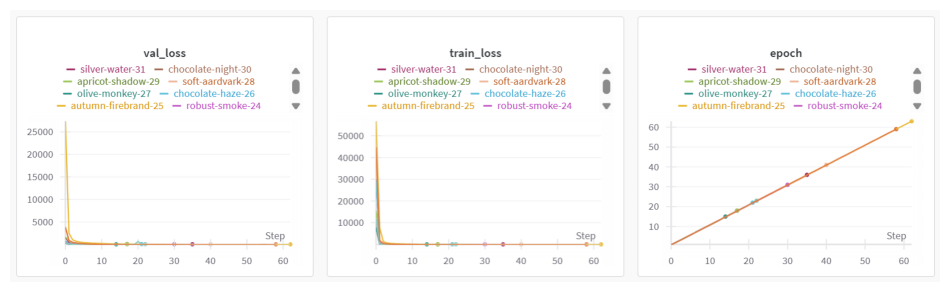

In [23]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image_path = "S1_NN_loss.png"
img = mpimg.imread(image_path)

plt.figure(figsize=(12, 6))
plt.imshow(img)
plt.axis("off")
plt.show()

Find the best model

In [24]:
import wandb
import os

api = wandb.Api()

project_path = "yixuan228-imperial-college-london/DE_Groupwork G4"
runs = api.runs(project_path)  # Get all the runs

# save_dir = "wandb_artifacts"
# os.makedirs(save_dir, exist_ok=True)

Save all the model config

In [25]:
ls_summary, ls_config = [], []

best_run = None
best_val_loss = float('inf')

ls_config = [run.config for run in runs]
ls_summary = [run.summary._json_dict for run in runs]


Select the best model

In [26]:
best_run = None
best_loss = float("inf")  

for run in runs:
    # print(run.summary.keys())
    if "val_loss" in run.summary:  
        loss = run.summary["val_loss"]
        if loss < best_loss:  # best model with least loss
            best_loss = loss
            best_run = run

# Best model hyparparameters
if best_run:
    print("\nBest Model Found:")
    print(f"Run ID: {best_run.id}, Name: {best_run.name}, State: {best_run.state}")
    print(f"Lowest Validation Loss: {best_loss}")

    print("\nBest Model Hyperparameters (config):")
    for key, value in best_run.config.items():
        print(f"   {key}: {value}")

    print("\nBest Model Final Metrics (summary):")
    for key, value in best_run.summary.items():
        print(f"   {key}: {value}")
else:
    print("No valid runs found with 'loss' metric.")



Best Model Found:
Run ID: nbfzlfhc, Name: fearless-morning-12, State: finished
Lowest Validation Loss: 8.600484386515094

Best Model Hyperparameters (config):
   patience: 5
   max_epochs: 200
   hidden_units: 64
   hidden_layers: 2
   learning_rate: 0.001

Best Model Final Metrics (summary):
   _runtime: 19.7579481
   _step: 118
   _timestamp: 1742462047.419305
   _wandb: {'runtime': 19}
   epoch: 119
   train_loss: 8.823451982218003
   val_loss: 8.600484386515094


#### 3.1.4 Best NN Model Parameters

Using Nueral Network Models is a good way to predict the CO2 emssions based on the features given. After using W&B to grid search the hyperparameters grid, the best model is chosen based on the metric of validation loss.

The best model parameters are listed below:

**Hyperparameter**:\
    patience: 5\
    max_epochs: 200\
    hidden_units: 64\
    hidden_layers: 2\
    learning_rate: 0.001

**Running Performance:**\
    epoch: 119\
    Training loss: 8.823451982218003\
    Validation loss: 8.600484386515094




#### 3.1.5 K-fold on Best NN Model 

Initialize NN model configuration, set hyperparameter grid.

In [27]:
# Hyperparameter grid
hidden_size = 64    # Numbers of neurons in each hidden layer
num_layer = 2       # Numbers of hidden layers
learning_rate = 0.001     # Learning rates

num_epochs = 200  # Arbitrarily large; early stopping will likely stop earlier.
batch_size = 64
patience = 5      # Early stopping patience

input_size =  X_train_processed.shape[1]   # Input size 
output_size = 1             # Output size

Output k-fold validation results

In [28]:
from torch.utils.data import Subset
from torch import optim

# Save MSE and True/Predict Values---------------------------
nn_k_fold_mse = []
nn_k_fold_R2 = []
nn_k_fold_mae = []
nn_k_fold_mape = []   

# Train and Evaluate the model----------------------------
print(f'Best Neural Network Model:\n')
for fold, (train_index, val_index) in enumerate(k_fold.split(X_train_df)):

    # get the training and validation data
    train_subset  = Subset(train_dataset, train_index)
    val_subset = Subset(train_dataset, val_index)

    # Data loader
    train_loader = DataLoader(dataset=train_subset , batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(dataset=val_subset, batch_size=batch_size, shuffle=False)

    # Initialize and train the model
    nn_model = MultiLayerPerceptron(input_size, hidden_size, num_layer, output_size).to(device)

    criterion = nn.MSELoss()  # MSE as loss function
    optimizer = optim.Adam(nn_model.parameters(), lr=learning_rate)  # Adam as optimizer

    for epoch in range(num_epochs):
        nn_model.train()
        total_loss = 0
        i = 0

        for X_batch, y_batch in train_loader:

            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            y_pred = nn_model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # if (epoch+1) % 10 == 0:
        #     print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

    # Validate the model
    nn_model.eval()

    y_true_fold = []
    y_pred_fold = []

    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:

            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            y_pred = nn_model(X_batch)
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item()

            # y_true_fold.append(y_batch.cpu.numpy())     
            # y_pred_fold.append(y_pred.cpu.numpy())      

            y_true_fold.append(y_batch.cpu().detach().numpy())  # true value
            y_pred_fold.append(y_pred.cpu().detach().numpy())   # predicted value

    y_true_fold = np.concatenate(y_true_fold, axis=0).flatten()
    y_pred_fold = np.concatenate(y_pred_fold, axis=0).flatten()

    mse = mean_squared_error(y_true_fold, y_pred_fold)
    r2 = r2_score(y_true_fold, y_pred_fold)
    mae = mean_absolute_error(y_true_fold, y_pred_fold)
    mape = mean_absolute_percentage_error(y_true_fold, y_pred_fold)

    nn_k_fold_mse.append(mse)
    nn_k_fold_R2.append(r2)
    nn_k_fold_mae.append(mae)
    nn_k_fold_mape.append(mape)
    
    print(f"Fold {fold+1} Validation Dataset MSE: {mse:.4f}")

print(f"\nK-Fold Average MSE: {np.mean(nn_k_fold_mse):.4f}")
print(f"\n--------Finished training and validating the model!--------")


Best Neural Network Model:

Fold 1 Validation Dataset MSE: 5.7489
Fold 2 Validation Dataset MSE: 6.7702
Fold 3 Validation Dataset MSE: 8.6629
Fold 4 Validation Dataset MSE: 6.9164
Fold 5 Validation Dataset MSE: 7.5167
Fold 6 Validation Dataset MSE: 9.4694
Fold 7 Validation Dataset MSE: 10.9345
Fold 8 Validation Dataset MSE: 9.4360
Fold 9 Validation Dataset MSE: 7.4951
Fold 10 Validation Dataset MSE: 18.7536
Fold 11 Validation Dataset MSE: 9.9889
Fold 12 Validation Dataset MSE: 5.6913
Fold 13 Validation Dataset MSE: 8.8019
Fold 14 Validation Dataset MSE: 7.5253
Fold 15 Validation Dataset MSE: 7.3149
Fold 16 Validation Dataset MSE: 8.0723
Fold 17 Validation Dataset MSE: 8.8668
Fold 18 Validation Dataset MSE: 5.7073
Fold 19 Validation Dataset MSE: 7.2471
Fold 20 Validation Dataset MSE: 6.8096

K-Fold Average MSE: 8.3865

--------Finished training and validating the model!--------


Neural Network Model:
    Test Dataset MSE: 8.4037
    Test Dataset R2: 0.9976
    Test Dataset MAE: 2.0972
    Test Dataset MAPE: 0.0083


Text(0.5, 1.0, 'Neural Network Model: Observed vs Predicted values')

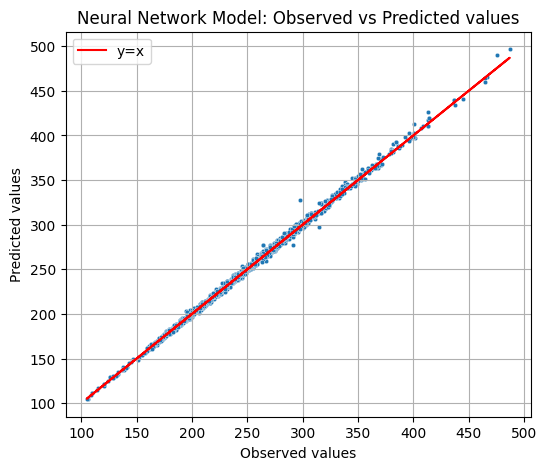

In [29]:
# Test the model on the test dataset------------------------   
# Using MSE as the evaluation metrics: Mean Squared Error, R2, MAE, MAPE
nn_model.eval()

# Get the prediction and true values
nn_test_true = []
nn_test_pred = []

val_loss = 0
with torch.no_grad():
    for X_batch, y_batch in test_Loader:

        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        y_pred = nn_model(X_batch)
        loss = criterion(y_pred, y_batch)
        val_loss += loss.item()

        nn_test_true.append(y_batch.cpu().detach().numpy())     # true value
        nn_test_pred.append(y_pred.cpu().detach().numpy())      # predicted value

# concatenate the true and predicted values
nn_test_true = np.concatenate(nn_test_true, axis=0).flatten()
nn_test_pred = np.concatenate(nn_test_pred, axis=0).flatten()

nn_test_r2 = r2_score(nn_test_pred, nn_test_true)
nn_test_mse = mean_squared_error(nn_test_pred, nn_test_true)
nn_test_mae = mean_absolute_error(nn_test_pred, nn_test_true)
nn_test_mape = mean_absolute_percentage_error(nn_test_pred, nn_test_true)

# Output
print(f'Neural Network Model:')
print(f"    Test Dataset MSE: {nn_test_mse:.4f}")
print(f"    Test Dataset R2: {nn_test_r2:.4f}")
print(f"    Test Dataset MAE: {nn_test_mae:.4f}")
print(f"    Test Dataset MAPE: {nn_test_mape:.4f}")

# Using plot
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
plot_pred_true(nn_test_true, nn_test_pred, ax)
plt.title('Neural Network Model: Observed vs Predicted values')

In [30]:
print(f"Test Dataset MSE: {nn_test_mse:.4f}")
print(f"Validation Dataset MSE: {np.mean(nn_k_fold_mse):.4f}")

Test Dataset MSE: 8.4037
Validation Dataset MSE: 8.3865


### 3.1.6 Save the NN Model Performance

Output of Best NN Model

- Output will include two types of data: Validation values, and Test Values, and combine those into one dataframe.

- Validation RSE:  1 x 20    Test RSE: 1 x 1

- Validation R2:   1 x 20    Test R2:  1 x 1

- Validation MAE:  1 x 20    Test MAE:  1 x 1

- Validation MAPE: 1 x 20    Test MAPE:  1 x 1

- So the output dataframe should include:

    - **4 rows**: RSE, R2, MAE and MAPE 
    
    - **21 cols**:  first 20 as validation metrics, with the last one being test metric

In [31]:
# Save the output of Best NN Model 
nn_metrics = pd.DataFrame([nn_k_fold_mse, nn_k_fold_R2, nn_k_fold_mae, nn_k_fold_mape])

# Add Test results
nn_metrics["Test_results"] = [nn_test_mse, nn_test_r2, nn_test_mae, nn_test_mape]


In [32]:
nn_metrics.columns = [f"fold_{i+1}" for i in range(20)] + ["Test"]
nn_metrics.index = ['MSE', 'R2', 'MAE', 'MAPE']


In [33]:
nn_metrics

,fold_1,fold_2,fold_3,fold_4,fold_5,fold_6,fold_7,fold_8,fold_9,fold_10,...,fold_12,fold_13,fold_14,fold_15,fold_16,fold_17,fold_18,fold_19,fold_20,Test
MSE,5.748903,6.770223,8.662851,6.916399,7.516706,9.469388,10.934547,9.436038,7.495071,18.753593,...,5.691262,8.801867,7.525272,7.314851,8.072349,8.866827,5.707318,7.247093,6.809605,8.403743
R2,0.998263,0.998205,0.997863,0.998040,0.997629,0.997401,0.996867,0.996873,0.997822,0.994686,...,0.998359,0.997289,0.997253,0.997856,0.997618,0.997293,0.998352,0.997605,0.998108,0.997614
MAE,1.950637,1.937659,2.241559,2.121958,2.147535,2.442742,2.405281,2.262093,2.239348,2.170436,...,1.883480,2.222586,2.053818,2.052139,2.289795,2.235571,1.905614,2.116100,1.925600,2.097183
MAPE,0.008071,0.007745,0.008673,0.008329,0.008658,0.010233,0.009630,0.009022,0.009065,0.009719,...,0.007523,0.009167,0.008331,0.008223,0.009173,0.008975,0.007617,0.008544,0.007593,0.008333


In [35]:
nn_test_pred_df = pd.DataFrame(nn_test_pred, columns=["y"])
nn_test_pred_df.to_csv("Workstream_1_ML_models/nn_test_pred.csv", index=False)  

In [ ]:
nn_metrics.to_csv("Best_NN_Model_performance.csv", index=True)